# Streetcar Delay Prediction - Deep Learning

GOAL: predict streetcar delays using a simple Keras model

Source dataset: : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da

# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

In [41]:
# libraries that had to explicitly installed for Paperspace Gradient
!pip install sklearn
!pip install seaborn
!pip install keras
!pip install tensorflow
!pip install pydot

In [43]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import datetime
import os
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
import pydot
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# from sklearn.preprocessing import CategoricalEncoder

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from subprocess import check_output
import seaborn as sns

#model libraries


from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model


In [12]:
# set overall parameters

dsxmode = False # overall is this being run in DSX?
csvmode = True # ingest from CSV
dbmode = False # ingest from database
pSpace = True # pSpace mode
savepath = '/home/paperspace/models/'
readpath = '/home/paperspace/data/dmprediction/'

testproportion = 0.01 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = True
includetext = True # switch to determine whether text fields are included in model
presaved = False # switch to determine whether to train model or load saved model
savemodel = True # switch to determine whether to save model
picklemodel = True # switch for code to allow pickling of Keras model
hctextmax = 7000
maxwords = 6000

targetthresh = 6.0
targetcontinuous = False # switch to determine whether target is continuous or 

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}

#time_of_day = {'overnight':[0,5],'morning_rush':[5,10],
 #             'midday':[10,15],'aft_rush':[15,19],'evening':[19,23]}
              


emptythresh = 6000
# to address imbalance in training data between zero (above targetthresh) and detractor (below targetthresh) specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
# consider calculating these values from actual skew rather than hard-coding them here
zero_weight = 1.0
one_weight = 72.8

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.0003 #0.003
l2_lambda = 0.0003 #7.5
loss_func = "binary_crossentropy"
if targetcontinuous:
    output_activation = "linear"
else:
    output_activation = "hard_sigmoid"



In [13]:
# get the directory for that this notebook is in
rawpath = os.getcwd()
print("raw path is",rawpath)

raw path is /notebooks/manning/notebooks


In [14]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
print("path is", path)

path is /notebooks/manning/data/


In [15]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}
              

def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)
            
            

In [16]:
print("tod on",time_of_day['overnight']['start'])

tod on 0


In [17]:
print("tod  0",get_time(0))
print("tod 5",get_time(23))

tod  0 overnight
tod 5 evening


In [18]:
# constants for the streetcar problem
# same values saved in data_preparation notebook: pickled_input_dataframe, pickled_output_dataframe
pickled_data_file = '2014_2018.pkl'
pickled_dataframe = '2014_2018_df.pkl'

# Ingest data <a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [19]:
file_name = path + pickled_dataframe
merged_data = pd.read_pickle(file_name)
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,broadview and gerrard,Mechanical,9.0,18.0,s,4092,2015-01-01 01:25:00
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,galley and roncesvalles,Held By,14.0,23.0,s,4030,2015-01-01 01:44:00
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,king and sherborne,Mechanical,9.0,18.0,e,4147,2015-01-01 02:04:00
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,main st. and upper gerard,Investigation,29.0,39.0,s,4049,2015-01-01 02:12:00
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,gerrard and sumach,Mechanical,30.0,60.0,w,4114,2015-01-01 05:05:00


In [20]:
merged_data.shape

(83365, 11)

In [21]:
# define cols for year month day
# apar_ds["year"] = pd.DatetimeIndex(apar_ds['PMR_Open_Date']).year 
merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym
Report Date Time,,,,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,broadview and gerrard,Mechanical,9.0,18.0,s,4092,2015-01-01 01:25:00,2015,1,1
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,galley and roncesvalles,Held By,14.0,23.0,s,4030,2015-01-01 01:44:00,2015,1,1
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,king and sherborne,Mechanical,9.0,18.0,e,4147,2015-01-01 02:04:00,2015,1,1
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,main st. and upper gerard,Investigation,29.0,39.0,s,4049,2015-01-01 02:12:00,2015,1,1
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,gerrard and sumach,Mechanical,30.0,60.0,w,4114,2015-01-01 05:05:00,2015,1,1


In [22]:
# define cols for time of day
merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour
Report Date Time,,,,,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,broadview and gerrard,Mechanical,9.0,18.0,s,4092,2015-01-01 01:25:00,2015,1,1,1
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,galley and roncesvalles,Held By,14.0,23.0,s,4030,2015-01-01 01:44:00,2015,1,1,1
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,king and sherborne,Mechanical,9.0,18.0,e,4147,2015-01-01 02:04:00,2015,1,1,2
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,main st. and upper gerard,Investigation,29.0,39.0,s,4049,2015-01-01 02:12:00,2015,1,1,2
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,gerrard and sumach,Mechanical,30.0,60.0,w,4114,2015-01-01 05:05:00,2015,1,1,5


In [23]:
# define time of day column
merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
merged_data.head()

# add a special timeframe for weekends
# df['NewCol'] = df.apply(lambda x: segmentMatch(x['TimeCol'], x['ResponseCol']), axis=1)
# weekend_time(day, tod)
merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour,time_of_day
Report Date Time,,,,,,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,broadview and gerrard,Mechanical,9.0,18.0,s,4092,2015-01-01 01:25:00,2015,1,1,1,overnight
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,galley and roncesvalles,Held By,14.0,23.0,s,4030,2015-01-01 01:44:00,2015,1,1,1,overnight
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,king and sherborne,Mechanical,9.0,18.0,e,4147,2015-01-01 02:04:00,2015,1,1,2,overnight
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,main st. and upper gerard,Investigation,29.0,39.0,s,4049,2015-01-01 02:12:00,2015,1,1,2,overnight
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,gerrard and sumach,Mechanical,30.0,60.0,w,4114,2015-01-01 05:05:00,2015,1,1,5,morning_rush


In [24]:
merged_data['time_of_day'].value_counts()

morning_rush     25907
aft_rush         13655
midday           13546
evening           8928
wmidday           5370
wmorning_rush     4210
waft_rush         3481
overnight         3274
wevening          3223
wovernight        1771
Name: time_of_day, dtype: int64

In [25]:
# define target column
if targetcontinuous:
    merged_data = merged_data.rename(columns = {'Min Delay':'target'})
else:
    # np.where(df['age']>=50, 'yes', 'no')
    merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
merged_data['target'].head()
    

Report Date Time
2015-01-01 01:25:00    1
2015-01-01 01:44:00    1
2015-01-01 02:04:00    1
2015-01-01 02:12:00    1
2015-01-01 05:05:00    1
Name: target, dtype: int64

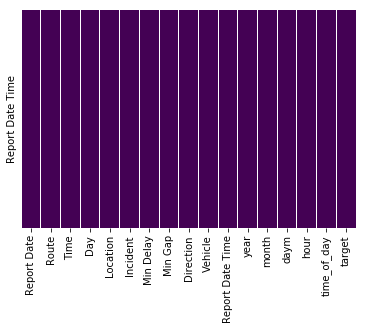

In [26]:
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# Define test / training sets;  encode categorical values; process text field

In [27]:
# get training and test data set

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)



Through train test split. Test proportion:
0.01


# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [28]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle', 'Report Date Time', 'year', 'month', 'daym', 'hour', 'time_of_day', 'target']


In [29]:
# define the required column lists

textcols = ['Incident'] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
continuouscols = [] # columns to deal with as continuous values - no embeddings
if targetcontinuous:
    excludefromcolist = ['Report Date','Time','Report Date Time','Min Gap','target','time_of_day','Vehicle'] # columns to exclude completely from the model
else:
    # if target column is not renamed Min Delay put Min Delay in exclusion list
    excludefromcolist = ['Report Date','Time','Report Date Time','Min Gap','Min Delay','target','time_of_day','Vehicle'] # columns to exclude completely from the model
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))

# print column list lengths and contents:
print("allcols",len(allcols))
print("excludefromcolist",len(excludefromcolist))
print(excludefromcolist)
print("textcols",len(textcols))
print(textcols)
print("continuouscols",len(continuouscols))
print(continuouscols)
print("collist",len(collist))
print(collist)

allcols 17
excludefromcolist 8
['Report Date', 'Time', 'Report Date Time', 'Min Gap', 'Min Delay', 'target', 'time_of_day', 'Vehicle']
textcols 1
['Incident']
continuouscols 0
[]
collist 8
['Location', 'year', 'Day', 'Route', 'month', 'daym', 'hour', 'Direction']


In [30]:
# ensure continuous columns have numeric type
for col in continuouscols:
    print("col is",col)
    merged_data[col] = merged_data[col].astype(float)
    print("got through one")
    superset_data[col] = superset_data[col].astype(float)

In [31]:
merged_data.dtypes

Report Date         datetime64[ns]
Route                       object
Time                        object
Day                         object
Location                    object
Incident                    object
Min Delay                  float64
Min Gap                    float64
Direction                   object
Vehicle                     object
Report Date Time    datetime64[ns]
year                         int64
month                        int64
daym                         int64
hour                         int64
time_of_day                 object
target                       int64
dtype: object

# Deal with missing values <a name='bookmark' />
<a href=#linkanchor>Back to link list</a>

In [32]:
# fill missing values

def fill_missing(dataset):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)





In [33]:
# process categorical data
# replace values with category IDs in the categorical columns
# 


lelist = {}

for col in collist:
    le = LabelEncoder()
    if verboseout:
        print("processing ",col)
    # fit on superset to ensure encoding includes future data but only model on past data
    # np.hstack([superset_data[col]])
    le.fit(np.hstack([merged_data[col]]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    lelist[col] = le
    del le
    
    
train.head(5)
    

processing  Location


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


processing  year
processing  Day
processing  Route
processing  month
processing  daym
processing  hour
processing  Direction


,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour,time_of_day,target
Report Date Time,,,,,,,,,,,,,,,,,
2018-03-03 14:02:00,2018-03-03,9,14:02:00,2,3371,Held By,10.0,17.0,2,bad vehicle,2018-03-03 14:02:00,4,2,2,14,wmidday,1
2018-08-23 11:40:00,2018-08-23,4,11:40:00,4,441,Mechanical,6.0,12.0,2,4147,2018-08-23 11:40:00,4,7,22,11,midday,1
2015-06-15 06:51:00,2015-06-15,7,06:51:00,1,9044,Late Leaving Garage,5.0,10.0,2,4057,2015-06-15 06:51:00,1,5,14,6,morning_rush,0
2016-09-21 05:05:00,2016-09-21,4,05:05:00,6,3489,Late Leaving Garage,5.0,10.0,2,4029,2016-09-21 05:05:00,2,8,20,5,morning_rush,0
2018-08-29 17:29:00,2018-08-29,10,17:29:00,6,9807,Mechanical,6.0,12.0,5,4447,2018-08-29 17:29:00,4,7,28,17,aft_rush,1


In [34]:
train['Incident'].head(10)

Report Date Time
2018-03-03 14:02:00                Held By
2018-08-23 11:40:00             Mechanical
2015-06-15 06:51:00    Late Leaving Garage
2016-09-21 05:05:00    Late Leaving Garage
2018-08-29 17:29:00             Mechanical
2018-05-01 17:01:00                Held By
2015-08-15 01:30:00             Mechanical
2014-10-14 06:22:00              Diversion
2015-09-04 17:22:00     Emergency Services
2015-02-24 14:20:00             Mechanical
Name: Incident, dtype: object

In [35]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)

from keras.preprocessing.text import Tokenizer

# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    
    # Tokenizer lower cases and removes punctuation by default
    tok_raw = Tokenizer(num_words=maxwords,lower=True)
    tok_raw.fit_on_texts(train[col])
    train[col] = tok_raw.texts_to_sequences(train[col])
    test[col] = tok_raw.texts_to_sequences(test[col])
    


processing text col Incident


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
train['Incident'].head(10)

Report Date Time
2018-03-03 14:02:00       [3, 4]
2018-08-23 11:40:00          [1]
2015-06-15 06:51:00    [5, 6, 7]
2016-09-21 05:05:00    [5, 6, 7]
2018-08-29 17:29:00          [1]
2018-05-01 17:01:00       [3, 4]
2015-08-15 01:30:00          [1]
2014-10-14 06:22:00         [15]
2015-09-04 17:22:00     [13, 14]
2015-02-24 14:20:00          [1]
Name: Incident, dtype: object

In [37]:
# define max values for embeddings


max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    maxtrain = np.max(train[(train[cols].map(len) != 0)][cols].map(max))
    maxtest = np.max(test[(test[cols].map(len) != 0)][cols].map(max))
    if verboseout:
        print("maxtrain.max()",maxtrain)
        print("maxtest .max()",maxtest)
    max_dict[cols] = max(maxtrain,maxtest)
    # max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+20
    # np.max(df[(df['seq_item_description'].map(len) != 0)].seq_item_description.map(max))
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

if textmax < hctextmax:
    textmax = hctextmax
        
print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



maxtrain.max() 17
maxtest .max() 17
textmax 7000
max_dict {'Location': 10074, 'year': 6, 'Day': 7, 'Route': 15, 'month': 12, 'daym': 31, 'hour': 24, 'Direction': 6, 'Incident': 17}


# Split training set into train / validate

In [38]:
# define and scale target and get validation sets

dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head()

    




(66024, 17)
(16507, 17)


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [39]:
# define keras variables
from keras.preprocessing.sequence import pad_sequences

# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input
X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)
print("keras variables defined")
print("X_train_list",X_train_list)





cat col is Location
cat col is year
cat col is Day
cat col is Route
cat col is month
cat col is daym
cat col is hour
cat col is Direction
text col is Incident
cat col is Location
cat col is year
cat col is Day
cat col is Route
cat col is month
cat col is daym
cat col is hour
cat col is Direction
text col is Incident
cat col is Location
cat col is year
cat col is Day
cat col is Route
cat col is month
cat col is daym
cat col is hour
cat col is Direction
text col is Incident
keras variables defined
X_train_list [array([8096, 5285, 6781, ..., 9088, 6097, 7953]), array([2, 1, 3, ..., 4, 0, 0]), array([3, 4, 2, ..., 6, 0, 4]), array([ 4,  7,  4, ..., 13,  7, 12]), array([ 7, 10,  4, ...,  7, 11,  2]), array([20, 25, 12, ...,  0, 18, 12]), array([11, 14, 18, ..., 16, 20,  6]), array([2, 4, 5, ..., 2, 5, 2]), array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [45]:
# define model in Keras

def get_model():
    
          
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    
      
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    
    
    
    # define layers for text columns
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        
    # define layers for continuous columns
    for col in continuouscols: 
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
    
    
              
    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])
    
    print("main_l", main_l)                                            
    
       
    
    # define output layer
    output = Dense(1, activation=output_activation) (main_l)
   
    # define model        
                                                  
    model = Model(inputlayerlist, output)
    
       
    # define optimizer
    optimizer = SGD(lr=learning_rate)
   
    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
         
    
    return model

    
model = get_model()

# FIX THIS
# plot_model(model, to_file='/home/paperspace/visualizations/streetcarmodel_dec16.png', show_shapes=True, show_layer_names=True)

# output model summary

model.summary()
    

    

about to define embeddings
textmax is 7000
col Incident
text input shape 17
max in the midst 27
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_32/concat:0", shape=(?, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 10)        100740      Location[0][0]                   
_______________________________________________________________________

In [48]:
BATCH_SIZE = 1000
# 200
epochs = 100
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",BATCH_SIZE)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)


model = get_model()
modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

text cols ['Incident']
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 100
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
about to define embeddings
textmax is 7000
col Incident
text input shape 17
max in the midst 27
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_48/concat:0", shape=(?, ?), dtype=float32)
Train on 66024 samples, validate on 16507 samples
Epoch 1/100
66024/66024 [==============================] - 7s 111us/step - loss: 0.7337 - acc: 0.5411 - weighted_acc: 0.5411 - val_loss: 0.7173 - val_acc: 0.5483 - val_weighted_acc: 0.5483
Epoch 2/100
66024/66024 [==============================] - 3s 42us/step - loss: 0.6990 - acc: 0.5727 - weighted_acc: 0.5727 - val_loss: 0.6939 - val_acc: 0.5766 - val_weighted_acc: 0.5766
Epoch 3/100
66024/66024 [==============================] - 3s 39us/step - loss: 0.6788 - acc: 0.5993 - weighted_acc: 0.5993 - val_loss: 0.6775 - val_acc: 0.60

Epoch 42/100
66024/66024 [==============================] - 3s 47us/step - loss: 0.5955 - acc: 0.7062 - weighted_acc: 0.7062 - val_loss: 0.6012 - val_acc: 0.7022 - val_weighted_acc: 0.7022
Epoch 43/100
66024/66024 [==============================] - 3s 47us/step - loss: 0.5953 - acc: 0.7058 - weighted_acc: 0.7058 - val_loss: 0.6020 - val_acc: 0.7021 - val_weighted_acc: 0.7021
Epoch 44/100
66024/66024 [==============================] - 3s 47us/step - loss: 0.5952 - acc: 0.7056 - weighted_acc: 0.7056 - val_loss: 0.6020 - val_acc: 0.7022 - val_weighted_acc: 0.7022
Epoch 45/100
66024/66024 [==============================] - 3s 47us/step - loss: 0.5949 - acc: 0.7055 - weighted_acc: 0.7055 - val_loss: 0.6019 - val_acc: 0.7017 - val_weighted_acc: 0.7017
Epoch 46/100
66024/66024 [==============================] - 3s 43us/step - loss: 0.5949 - acc: 0.7058 - weighted_acc: 0.7058 - val_loss: 0.6016 - val_acc: 0.7028 - val_weighted_acc: 0.7028
Epoch 47/100
66024/66024 [=============================

66024/66024 [==============================] - 3s 42us/step - loss: 0.5916 - acc: 0.7068 - weighted_acc: 0.7068 - val_loss: 0.5978 - val_acc: 0.7056 - val_weighted_acc: 0.7056
Epoch 86/100
66024/66024 [==============================] - 3s 40us/step - loss: 0.5907 - acc: 0.7076 - weighted_acc: 0.7076 - val_loss: 0.5978 - val_acc: 0.7050 - val_weighted_acc: 0.7050
Epoch 87/100
66024/66024 [==============================] - 3s 42us/step - loss: 0.5930 - acc: 0.7054 - weighted_acc: 0.7054 - val_loss: 0.5968 - val_acc: 0.6982 - val_weighted_acc: 0.6982
Epoch 88/100
66024/66024 [==============================] - 3s 44us/step - loss: 0.5956 - acc: 0.7036 - weighted_acc: 0.7036 - val_loss: 0.5951 - val_acc: 0.7042 - val_weighted_acc: 0.7042
Epoch 89/100
66024/66024 [==============================] - 3s 42us/step - loss: 0.5942 - acc: 0.7062 - weighted_acc: 0.7062 - val_loss: 0.5962 - val_acc: 0.7027 - val_weighted_acc: 0.7027
Epoch 90/100
66024/66024 [==============================] - 3s 42us/

In [49]:
modifier = "mar23"
savepath = path
if savemodel == True:
    model_json = model.to_json()
    with open(savepath+'model'+modifier+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(savepath+'dmweights'+modifier+'.h5')
    
    # save tokenizer tok_raw for text and label encoder for categorical cols
    with open(savepath+'tokenizer'+modifier+'.pickle', 'wb') as handle:
        pickle.dump(tok_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(savepath+'le'+modifier+'.pickle', 'wb') as handle2:
        pickle.dump(lelist, handle2, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved model, weights, tokenizer and label encoder to disk")
      
    model.save(savepath+'dmmodel'+modifier+'.h5')
    print("Saved model, weights, tokenizer and label encoder to disk")


Saved model, weights, tokenizer and label encoder to disk
Saved model, weights, tokenizer and label encoder to disk


# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [54]:
from keras.models import load_model
new_model = load_model(savepath+'dmmodel'+modifier+'.h5')

In [55]:
if presaved == True:
    BATCH_SIZE = 200
    epochs = 1
    modelfit2 = new_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

In [56]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ACCOUNT_NAME (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
CASE_OWNER_ALIAS (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1, 10)        22150       ACCOUNT_NAME[0][0]               
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 10)        2690        CASE_OWNER_ALIAS[0][0]           
__________________________________________________________________________________________________
SUPPORT_MI

# Predictions and renderings

In [121]:
# functions to parse and manipulate dates in the style of the input CSVs
import datetime
from datetime import date
def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [122]:
# predictions on training set

preds = model.predict(X_train, batch_size=BATCH_SIZE)

In [123]:
len(lelist)

11

In [124]:
preds.shape

(5950, 1)

In [125]:
preds[:50]

array([[ 0.47658885],
       [ 0.48568058],
       [ 0.51618594],
       [ 0.54550904],
       [ 0.48846439],
       [ 0.44110146],
       [ 0.35933176],
       [ 0.46696281],
       [ 0.46008301],
       [ 0.52748609],
       [ 0.45919886],
       [ 0.41886404],
       [ 0.39999038],
       [ 0.43974134],
       [ 0.41980836],
       [ 0.47716776],
       [ 0.43132985],
       [ 0.46688703],
       [ 0.51388305],
       [ 0.44410166],
       [ 0.45134065],
       [ 0.41294196],
       [ 0.40390512],
       [ 0.48919168],
       [ 0.4630186 ],
       [ 0.54636103],
       [ 0.47538921],
       [ 0.41760489],
       [ 0.44419828],
       [ 0.35426328],
       [ 0.35809675],
       [ 0.49904078],
       [ 0.4187327 ],
       [ 0.49405068],
       [ 0.4368012 ],
       [ 0.58154649],
       [ 0.40500203],
       [ 0.49542972],
       [ 0.45565513],
       [ 0.4841933 ],
       [ 0.47077447],
       [ 0.49711803],
       [ 0.44285139],
       [ 0.38223869],
       [ 0.38384244],
       [ 0

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


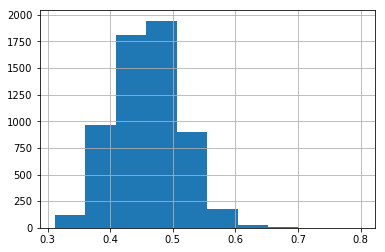

In [126]:
dtrain["predict"] = preds
dtrain.predict[:5]
if verboseout:
    dtrain.predict.hist()

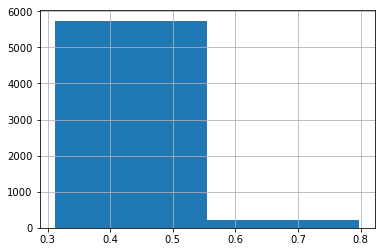

In [127]:
if verboseout:
    dtrain.predict.hist(bins=2)

In [128]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(dtrain.target))

<class 'numpy.ndarray'>
(5950, 1)
<class 'pandas.core.series.Series'>


In [131]:
# get rounded predictions 
dtrain["predround"] = preds.round().astype(int)
dtrain.predround[:5]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


810     0
7110    0
3967    1
3800    1
627     0
Name: predround, dtype: int64

In [132]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dtrain.target[:100000] - dtrain.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct train")
print((len(deltatr) - deltatr.sum())/len(deltatr))



1273.0
percentage correct train
0.786050420168


In [133]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


6508    0.488539
3460    0.523025
2945    0.388055
6663    0.397696
4871    0.365404
Name: predict, dtype: float32

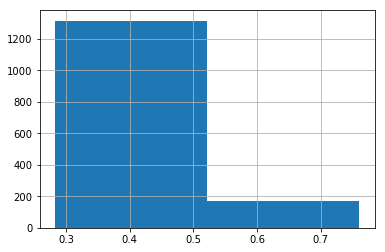

In [134]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [135]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


6508    0.0
3460    1.0
2945    0.0
6663    0.0
4871    0.0
4380    1.0
110     1.0
1582    1.0
6088    1.0
1823    1.0
Name: deltaval, dtype: float64
337.0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [136]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target,predround,predict,deltaval
3460,TS000149858,247,3/19/2018,0,6,2,1,1,1268,1,40,5,"[3, 3386, 1694, 99, 36, 2, 876, 99, 20, 738, 293]",1819,1,0.0,1,0.523025,1.0
4380,TS000162980,103,3/29/2018,0,11,18,0,0,988,1,40,5,"[22, 499, 5, 642, 159, 7, 349]",1578,0,0.0,1,0.519243,1.0
110,TS000130911,112,03/05/2018,0,6,0,0,1,216,1,5,2,"[10, 14, 105, 147]",439,0,0.0,1,0.525033,1.0
1582,TS000117826,188,2/18/2018,0,6,10,1,1,812,1,5,2,"[188, 64, 52, 2, 33, 320, 298, 1363, 4, 1, 60,...",1470,0,0.0,1,0.521524,1.0
6088,TS000841054,212,4/27/2018,0,6,10,0,0,629,1,40,5,"[745, 52, 2, 1774, 2292, 284, 867, 2, 90, 21, ...",412,0,0.0,1,0.504811,1.0
1823,TS000121491,73,2/22/2018,0,6,10,2,2,1171,1,5,0,"[4660, 1]",1819,1,0.0,1,0.529827,1.0
1512,TS000116911,63,2/15/2018,0,6,18,2,2,92,1,30,5,[],1819,1,0.0,1,0.507433,1.0
1680,TS000119274,1,2/19/2018,0,3,18,0,1,385,1,40,5,"[1, 33]",1819,1,0.0,1,0.512129,1.0
269,TS000177773,166,04/11/2018,0,6,4,2,0,1504,1,5,0,"[164, 210, 313]",1819,1,1.0,0,0.471071,1.0
1124,TS000112377,171,02/10/2018,0,6,2,1,1,1307,1,40,5,"[1, 767, 174, 284, 52, 2, 33]",523,0,0.0,1,0.516275,1.0


In [137]:
dvalidright.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target,predround,predict,deltaval
6508,TS000877452,236,05/04/2018,0,6,18,0,1,1001,1,7,2,"[1, 35, 50]",1912,0,0.0,0,0.488539,0.0
2945,TS000140258,0,03/12/2018,0,3,18,0,3,1129,1,40,5,"[2038, 21, 22, 436]",1007,0,0.0,0,0.388055,0.0
6663,TS000883281,108,05/08/2018,0,6,4,2,2,1731,1,7,5,"[84, 2922, 845]",50,0,0.0,0,0.397696,0.0
4871,TS000176645,7,04/11/2018,0,6,18,0,2,653,1,5,0,"[1931, 982, 545, 1836, 1358, 8, 7, 304, 274, 2...",1396,0,0.0,0,0.365404,0.0
4800,TS000175067,95,04/10/2018,0,6,4,0,2,649,1,5,2,"[601, 194, 7, 1, 188]",1799,0,0.0,0,0.409905,0.0
285,TS000211851,221,4/16/2018,0,6,4,1,2,1306,1,7,2,"[154, 4, 2290]",866,0,0.0,0,0.411263,0.0
782,TS000108074,34,02/06/2018,0,6,15,0,2,1708,1,40,5,"[2975, 182, 327]",1819,1,0.0,0,0.423175,0.0
3766,TS000168267,95,04/04/2018,0,6,18,0,2,1917,1,2,0,"[386, 76, 219, 59, 9, 169, 535, 750, 234, 249,...",2148,0,0.0,0,0.401332,0.0
4870,TS000176620,82,04/11/2018,0,6,18,0,1,1789,1,5,0,"[75, 12, 10]",2179,0,0.0,0,0.490349,0.0
1474,TS000116479,199,2/15/2018,0,6,7,0,1,2032,1,30,0,"[184, 82, 137, 1, 118, 320, 551, 144, 16, 158,...",1327,0,0.0,0,0.450237,0.0


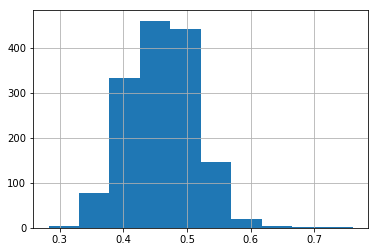

In [138]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

In [139]:
# ,encoding = "ISO-8859-1"
if dsxmode == False:
    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')

In [140]:
dtrain.target[:50]

810     0.0
7110    0.0
3967    0.0
3800    0.0
627     0.0
230     0.0
3195    0.0
361     0.0
5882    0.0
6011    0.0
4215    0.0
3192    0.0
591     0.0
5788    0.0
1886    0.0
5492    0.0
7373    0.0
1107    0.0
824     0.0
2086    0.0
6524    0.0
2767    0.0
5654    0.0
648     0.0
1400    0.0
5226    0.0
4942    0.0
2969    0.0
3590    0.0
3861    0.0
2428    0.0
1347    0.0
2021    0.0
7254    0.0
3997    0.0
5377    0.0
4383    0.0
5244    0.0
1659    0.0
208     0.0
1081    0.0
3524    0.0
4829    0.0
5968    0.0
7097    0.0
1699    0.0
5313    0.0
239     0.0
680     0.0
4965    0.0
Name: target, dtype: float64

In [141]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


337.0
percentage correct validate
0.773521505376


dict_keys(['val_loss', 'val_acc', 'val_weighted_acc', 'loss', 'acc', 'weighted_acc'])


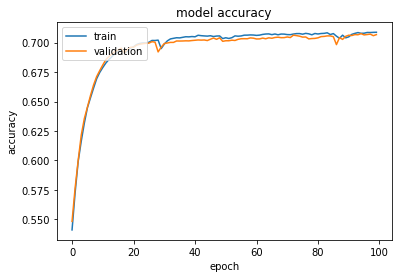

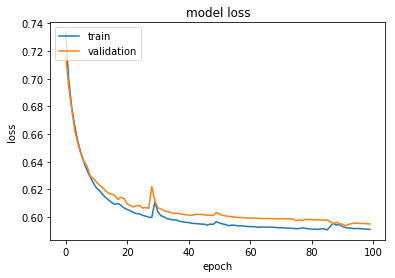

In [50]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

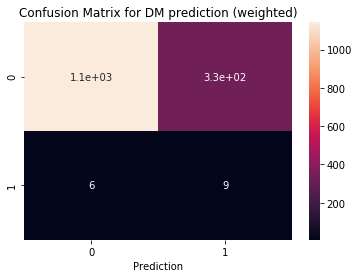

In [143]:
from sklearn import metrics

cfmap=metrics.confusion_matrix(y_true=dvalid['target'],  # True labels
                         y_pred=dvalid["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for DM prediction (weighted)")
plt.show()

In [144]:
model.metrics_names

['loss', 'acc', 'weighted_acc']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at IBM Canada.

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.